investigate border generation
- time(efficiency)
- diversity

In [1]:
# import modules
import numpy as np
import os
import sys
import torch
import time

from deepvisualinsight.utils_advanced import get_border_points_exp, get_border_points_exp2, get_border_points_exp1
from deepvisualinsight.utils import batch_run
import deepvisualinsight.MMS as MMS

In [2]:
content_path = "E:\\DVI_exp_data\\RQ1\\fix_border"
sys.path.append(content_path)

from Model.model import *

net = resnet18()
classes = ("airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

mms = MMS(content_path, net, 10, 200, 10, 512, 10, classes, cmap="tab10", resolution=100, neurons=256, verbose=1, temporal=False, split=-1, advance_border_gen=True, alpha=0.6, attack_device="cuda:0")

Finish loading content!


In [3]:
EPOCH = 100


In [4]:
training_data = mms.training_data.to(mms.device)
training_labels = mms.training_labels

model_location = os.path.join(mms.model_path, "Epoch_{:d}".format(EPOCH), "subject_model.pth")
net.load_state_dict(torch.load(model_location, map_location=torch.device("cpu")))
net = net.to(mms.device)
net.eval()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

0. pure random sample

In [5]:
confs = batch_run(net, training_data, 10)
preds = np.argmax(confs, axis=1).squeeze()

# Adversarial attacks
t0=time.time()
border_points,curr_samples, tot_num = get_border_points_exp1(model=net, input_x=training_data, confs=confs,
                                                            predictions=preds, device=mms.device, alpha=mms.alpha,
                                                            num_adv_eg=5000, num_cls=10, verbose=0)
t1=time.time()
t1-t0

100%|██████████| 250/250 [00:08<00:00, 28.62it/s]


250.35062456130981

In [7]:
border_points = mms.get_representation_data(EPOCH, border_points)
preds = mms.get_pred(EPOCH,border_points)
preds = np.argmax(preds,axis=1)
preds = np.squeeze(preds)
out = np.bincount(preds)

100%|██████████| 25/25 [00:00<00:00, 6243.75it/s]


In [8]:
from scipy.stats import entropy
out = out/np.sum(out)
out, entropy(out)

(array([0.1882, 0.013 , 0.0298, 0.2494, 0.1072, 0.2604, 0.0322, 0.017 ,
        0.0906, 0.0122]),
 1.8628095709276262)

In [9]:
entropy(curr_samples/np.sum(curr_samples)), np.std(curr_samples)

(3.794194108821966, 3.804762809839276)

In [16]:
grid_view, decision_view =mms.get_epoch_decision_view(EPOCH, resolution=200)
grid_view = grid_view.reshape(-1, 2)
decision_view = decision_view.reshape(-1,3)
from sklearn.neighbors import NearestNeighbors
nbs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(grid_view)

target_samples = border_points
repr_2d = mms.batch_project(target_samples, EPOCH)
_, indices = nbs.kneighbors(repr_2d)
indices = indices.squeeze()
sample_colors = decision_view[indices]

c1 = np.zeros(indices.shape[0], dtype=np.bool)
c1[sample_colors[:,0]>0.85] = 1

c2 = np.zeros(indices.shape[0], dtype=np.bool)
c2[sample_colors[:,1]>0.85] = 1

c3 = np.zeros(indices.shape[0], dtype=np.bool)
c3[sample_colors[:,2]>0.85] = 1
c = np.logical_and(c1,c2)
c=np.logical_and(c, c3)

np.sum(c), len(c), np.sum(c)/len(c)

Computing decision regions ...
Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000220274011D0>
Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000220CE05F3C8>
Instructions for updating:
Use tf.identity instead.


100%|██████████| 200/200 [00:00<00:00, 6072.06it/s]


Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000022027BDFDA0>


(3673, 5000, 0.7346)

E:\xianglin\git_space\DeepVisualInsight\deepvisualinsight\MMS.py:1000: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  color=color, zorder=2, picker=mpl.rcParams['lines.markersize'])


Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000220D3BEA710>
Computing decision regions ...
Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002202AE30748>


100%|██████████| 50/50 [00:00<00:00, 6267.26it/s]

Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002202989F860>


Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000220FD6EB1D0>


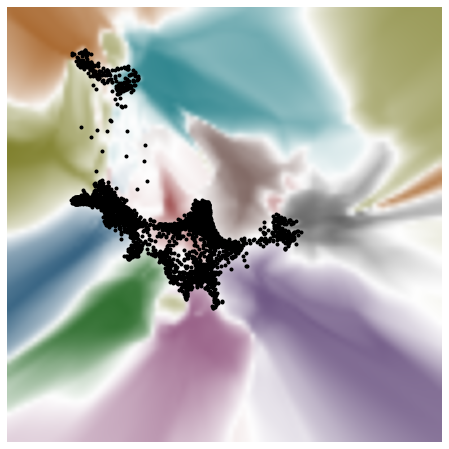

In [17]:
# visualize
img_save_location = os.path.join(mms.content_path, "img")

mms.customize_visualize(EPOCH, target_samples, None, None, None,
                        os.path.join(img_save_location, "test_{:d}".format(EPOCH)), np.arange(-len(c), 0, 1))

1. random sample, 500 per class

In [5]:
confs = batch_run(net, training_data, 10)
preds = np.argmax(confs, axis=1).squeeze()

# Adversarial attacks
t0=time.time()
border_points,curr_samples, tot_num = get_border_points_exp(model=net, input_x=training_data, confs=confs,
                                                     predictions=preds, device=mms.device, alpha=mms.alpha,
                                                     num_adv_eg=5000, num_cls=10, verbose=0)
t1=time.time()
t1-t0

100%|██████████| 10/10 [04:13<00:00, 25.35s/it]


253.49332237243652

In [6]:
border_points = mms.get_representation_data(EPOCH, border_points)
preds = mms.get_pred(EPOCH, border_points)
preds = preds + 1e-8

sort_preds = np.sort(preds)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])

border = np.zeros(len(diff), dtype=np.bool)
border[diff < 0.1] = 1
s = np.sum(border)
s

100%|██████████| 25/25 [00:00<00:00, 4988.71it/s]


5000

In [11]:
preds = mms.get_pred(EPOCH,border_points[border])
preds = np.argmax(preds,axis=1)
preds = np.squeeze(preds)
out = np.bincount(preds)

100%|██████████| 25/25 [00:00<00:00, 4177.76it/s]


In [12]:
from scipy.stats import entropy
out = out/np.sum(out)
out, entropy(out)

(array([0.1926, 0.0176, 0.0276, 0.2274, 0.1136, 0.2518, 0.0296, 0.0176,
        0.1082, 0.014 ]),
 1.894230113442687)

In [17]:
entropy(curr_samples/np.sum(curr_samples)), np.std(curr_samples)

(3.799361221723913, 3.799009811541001)

In [13]:
grid_view, decision_view =mms.get_epoch_decision_view(EPOCH, resolution=200)
grid_view = grid_view.reshape(-1, 2)
decision_view = decision_view.reshape(-1,3)
from sklearn.neighbors import NearestNeighbors
nbs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(grid_view)

target_samples = border_points[border]
repr_2d = mms.batch_project(target_samples, EPOCH)
_, indices = nbs.kneighbors(repr_2d)
indices = indices.squeeze()
sample_colors = decision_view[indices]

c1 = np.zeros(indices.shape[0], dtype=np.bool)
c1[sample_colors[:,0]>0.85] = 1

c2 = np.zeros(indices.shape[0], dtype=np.bool)
c2[sample_colors[:,1]>0.85] = 1

c3 = np.zeros(indices.shape[0], dtype=np.bool)
c3[sample_colors[:,2]>0.85] = 1
c = np.logical_and(c1,c2)
c=np.logical_and(c, c3)

np.sum(c), len(c), np.sum(c)/len(c)

Computing decision regions ...
Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000184DDC8CE80>
Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001851C499550>
Instructions for updating:
Use tf.identity instead.


100%|██████████| 200/200 [00:00<00:00, 5729.41it/s]


Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001851B935DD8>


(3554, 5000, 0.7108)

E:\xianglin\git_space\DeepVisualInsight\deepvisualinsight\MMS.py:1000: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  color=color, zorder=2, picker=mpl.rcParams['lines.markersize'])


Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001852BE0D588>
Computing decision regions ...
Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001852BE07438>


100%|██████████| 50/50 [00:00<00:00, 6267.08it/s]

Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000018540121F60>


Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001852BE07F28>


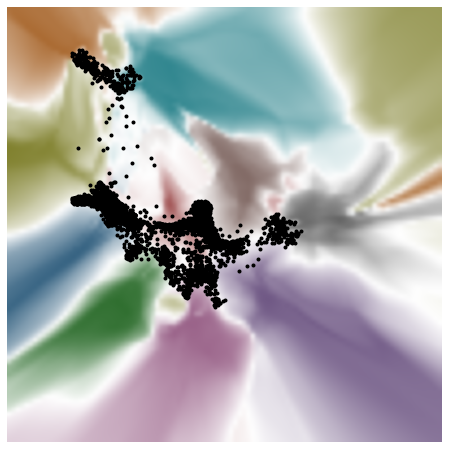

In [14]:
# visualize
img_save_location = os.path.join(mms.content_path, "img")

mms.customize_visualize(EPOCH, target_samples, None, None, None,
                        os.path.join(img_save_location, "test_{:d}".format(EPOCH)), np.arange(-len(c), 0, 1))


2. sample with probabilities

In [6]:
# hyperparameters search
lambd = np.arange(0., 0.25, 0.05)
t = []
curr_samples_std = []
pred_std = []
for l in lambd:
    confs = batch_run(net, training_data, 10)
    preds = np.argmax(confs, axis=1).squeeze()
    # Adversarial attacks
    t0=time.time()
    border_points, curr_samples, tot_num = get_border_points_exp2(model=net, input_x=training_data, confs=confs,
                                          predictions=preds, device=mms.device, alpha=mms.alpha,
                                          num_adv_eg=5000, num_cls=10, lambd=l, verbose=0)
    t1=time.time()
    t.append(round(t1-t0))

    border_points = mms.get_representation_data(EPOCH, border_points)
    preds = mms.get_pred(EPOCH, border_points)
    preds = preds + 1e-8

    preds = mms.get_pred(EPOCH,border_points)
    preds = np.argmax(preds,axis=1)
    preds = np.squeeze(preds)
    out = np.bincount(preds)
    pred_std.append(np.std(out))
    curr_samples_std.append(np.std(curr_samples))

100%|██████████| 25/25 [00:00<00:00, 5040.99it/s]


In [7]:
pred_std, curr_samples_std, t

([454.9217515133784,
  461.15810737750235,
  451.0975504256258,
  466.1105019198774,
  472.3638428161072],
 [0.6045098003882418,
  1.9801483919951526,
  7.3521643743631255,
  13.357016004452861,
  15.927924077923612],
 [245, 250, 251, 242, 244])

In [20]:
confs = batch_run(net, training_data, 10)
preds = np.argmax(confs, axis=1).squeeze()
t0=time.time()
border_points, curr_samples, tot_num = get_border_points_exp2(model=net, input_x=training_data, confs=confs,
                                                              predictions=preds, device=mms.device, alpha=mms.alpha,
                                                              num_adv_eg=5000, num_cls=10, lambd=0.05, verbose=0)
t1=time.time()

100%|██████████| 250/250 [00:07<00:00, 33.69it/s]


In [6]:
border_points = mms.get_representation_data(EPOCH, border_points)
preds = mms.get_pred(EPOCH, border_points)
preds = preds + 1e-8

sort_preds = np.sort(preds)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])

border = np.zeros(len(diff), dtype=np.bool)
border[diff < 0.1] = 1
s = np.sum(border)
s

100%|██████████| 25/25 [00:00<00:00, 5025.53it/s]


5000

In [7]:
preds = mms.get_pred(EPOCH,border_points[border])
preds = np.argmax(preds,axis=1)
preds = np.squeeze(preds)
out = np.bincount(preds)

100%|██████████| 25/25 [00:00<00:00, 4175.93it/s]


In [8]:
from scipy.stats import entropy
entropy(out/np.sum(out))

1.86892219630211

In [14]:
entropy(curr_samples/np.sum(curr_samples)), np.std(curr_samples)

(3.8066476881087796, 3.793164938176144)

In [12]:
grid_view, decision_view =mms.get_epoch_decision_view(EPOCH, resolution=200)
grid_view = grid_view.reshape(-1, 2)
decision_view = decision_view.reshape(-1,3)
from sklearn.neighbors import NearestNeighbors
nbs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(grid_view)

target_samples = border_points[border]
repr_2d = mms.batch_project(target_samples, EPOCH)
_, indices = nbs.kneighbors(repr_2d)
indices = indices.squeeze()
sample_colors = decision_view[indices]

c1 = np.zeros(indices.shape[0], dtype=np.bool)
c1[sample_colors[:,0]>0.85] = 1

c2 = np.zeros(indices.shape[0], dtype=np.bool)
c2[sample_colors[:,1]>0.85] = 1

c3 = np.zeros(indices.shape[0], dtype=np.bool)
c3[sample_colors[:,2]>0.85] = 1
c = np.logical_and(c1,c2)
c=np.logical_and(c, c3)

np.sum(c), len(c), np.sum(c)/len(c)

Computing decision regions ...
Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000013077F76940>
Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000130264F8D30>
Instructions for updating:
Use tf.identity instead.


100%|██████████| 200/200 [00:00<00:00, 5729.57it/s]


Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000130B3DAE208>


(3603, 5000, 0.7206)

E:\xianglin\git_space\DeepVisualInsight\deepvisualinsight\MMS.py:1000: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  color=color, zorder=2, picker=mpl.rcParams['lines.markersize'])


Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001311553AD30>
Computing decision regions ...
Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000013029B7A160>


100%|██████████| 50/50 [00:00<00:00, 5581.84it/s]

Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000013129B65FD0>


Keras encoder model loaded from <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000130B81512B0>


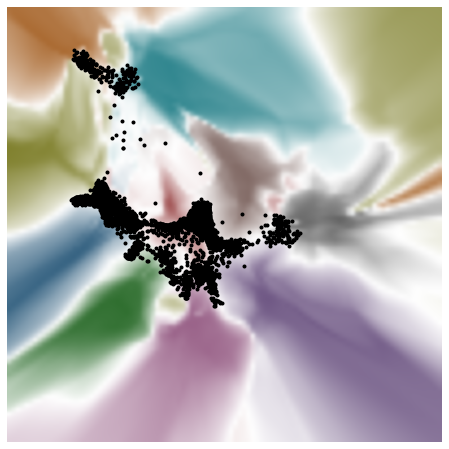

In [13]:
# visualize
img_save_location = os.path.join(mms.content_path, "img")

mms.customize_visualize(EPOCH, target_samples, None, None, None,
                        os.path.join(img_save_location, "test_{:d}".format(EPOCH)), np.arange(-len(c), 0, 1))

3. search for hyper-parameters for different epochs

In [5]:
# 40 epoch
# hyperparameters search
lambd = np.arange(0., 0.25, 0.05)
t = []
curr_samples_std = []
pred_std = []
for l in lambd:
    confs = batch_run(net, training_data, 10)
    preds = np.argmax(confs, axis=1).squeeze()
    # Adversarial attacks
    t0=time.time()
    border_points, curr_samples, tot_num = get_border_points_exp2(model=net, input_x=training_data, confs=confs,
                                                                  predictions=preds, device=mms.device, alpha=0.6,
                                                                  num_adv_eg=5000, num_cls=10, lambd=l, verbose=0)
    t1=time.time()
    t.append(round(t1-t0))

    border_points = mms.get_representation_data(EPOCH, border_points)
    preds = mms.get_pred(EPOCH, border_points)
    preds = preds + 1e-8

    preds = mms.get_pred(EPOCH,border_points)
    preds = np.argmax(preds,axis=1)
    preds = np.squeeze(preds)
    out = np.bincount(preds)
    pred_std.append(np.std(out))
    curr_samples_std.append(np.std(curr_samples))

100%|██████████| 25/25 [00:00<00:00, 5039.05it/s]


In [6]:
pred_std, curr_samples_std, t

([500.5375110818369,
  492.3378921025681,
  483.78610976339536,
  485.2716764864811,
  493.10262623514797],
 [0.4331908597692873,
  4.275107391619132,
  18.02001630560641,
  30.028299409591924,
  34.79988647632966],
 [432, 440, 406, 390, 387])

In [9]:
# 160 epoch
# hyperparameters search
lambd = np.arange(0., 0.25, 0.05)
t = []
curr_samples_std = []
pred_std = []
for l in lambd:
    confs = batch_run(net, training_data, 10)
    preds = np.argmax(confs, axis=1).squeeze()
    # Adversarial attacks
    t0=time.time()
    border_points, curr_samples, tot_num = get_border_points_exp2(model=net, input_x=training_data, confs=confs,
                                                                  predictions=preds, device=mms.device, alpha=0.6,
                                                                  num_adv_eg=5000, num_cls=10, lambd=l, verbose=0)
    t1=time.time()
    t.append(round(t1-t0))

    border_points = mms.get_representation_data(EPOCH, border_points)
    preds = mms.get_pred(EPOCH, border_points)
    preds = preds + 1e-8

    preds = mms.get_pred(EPOCH,border_points)
    preds = np.argmax(preds,axis=1)
    preds = np.squeeze(preds)
    out = np.bincount(preds)
    pred_std.append(np.std(out))
    curr_samples_std.append(np.std(curr_samples))

100%|██████████| 25/25 [00:00<00:00, 4991.32it/s]


In [10]:
pred_std, curr_samples_std, t

([311.5551315578031,
  312.05608470273415,
  300.25222730231326,
  299.9296584201036,
  296.80296494475925],
 [0.5258737584977438,
  4.976487928124153,
  7.418362269762249,
  10.426935679015239,
  12.996105779505596],
 [371, 375, 369, 365, 365])

In [5]:
confs = batch_run(net, training_data, 10)
preds = np.argmax(confs, axis=1).squeeze()
t0=time.time()
border_points, curr_samples, tot_num = get_border_points_exp2(model=net, input_x=training_data, confs=confs,
                                                              predictions=preds, device=mms.device, alpha=0.6,
                                                              num_adv_eg=5000, num_cls=10, lambd=0.05, verbose=0)
t1=time.time()

100%|██████████| 250/250 [00:08<00:00, 29.00it/s]


In [6]:
t1-t0

249.82840180397034

mnist dataset

In [18]:
content_path = "E:\\DVI_exp_data\\resnet18_fashionmnist"
sys.path.append(content_path)

from Model.model import *

net = resnet18()
classes = ("airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

mms = MMS(content_path, net, 10, 10, 10, 512, 10, classes, cmap="tab10", resolution=100, neurons=256, verbose=1, temporal=False, split=-1, advance_border_gen=True, alpha=0.5, attack_device="cuda:0")

Finish loading content!


In [19]:
EPOCH = 30

In [20]:
training_data = mms.training_data.to(mms.device)
training_labels = mms.training_labels

model_location = os.path.join(mms.model_path, "Epoch_{:d}".format(EPOCH), "subject_model.pth")
net.load_state_dict(torch.load(model_location, map_location=torch.device("cpu")))
net = net.to(mms.device)
net.eval()


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
confs = batch_run(net, training_data, 10)
preds = np.argmax(confs, axis=1).squeeze()
t0=time.time()
border_points, curr_samples, tot_num = get_border_points_exp2(model=net, input_x=training_data, confs=confs,
                                                              predictions=preds, device=mms.device, alpha=0.5,
                                                              num_adv_eg=5000, num_cls=10, lambd=0.05, verbose=0)
t1=time.time()

100%|██████████| 300/300 [00:03<00:00, 75.37it/s]


In [24]:
t1-t0

252.44607210159302

In [14]:
t1-t0

227.41115474700928

In [7]:
t1-t0

226.90947842597961

In [26]:
np.std(curr_samples)

1.6223744220839091

In [17]:
sys.path.remove(content_path)